# Data Analysis

## Import

In [1]:
import pandas as pd # For handling and analyzing tabular data

# For visualization
import seaborn as sns
import matplotlib.pyplot as plt

import re # For validating and manipulating text
import numpy as np # For numeric calculation

## Read cleaned data from CSV file

In [2]:
anime_data = pd.read_csv('./data/anime_data_cleaned.csv')

# Check
anime_data

,ID,Title,Alternative Title (en),Media Type,Status,Premiered Season,Genres,User Score,Number of Members,Studios,Rating
0,2471,Doraemon (1979),Doraemon,tv,finished_airing,Spring 1979,"Adventure, Anthropomorphic, Comedy, Fantasy, K...",7.86,66328,Shin-Ei Animation,pg
1,813,Dragon Ball Z,Dragon Ball Z,tv,finished_airing,Spring 1989,"Action, Adventure, Comedy, Fantasy, Martial Ar...",8.19,1261770,Toei Animation,pg_13
2,966,Crayon Shin-chan,Shin Chan,tv,currently_airing,Spring 1992,"Comedy, Ecchi, School, Seinen",7.80,87291,Shin-Ei Animation,g
3,170,Slam Dunk,Slam Dunk,tv,finished_airing,Fall 1993,"School, Shounen, Sports, Team Sports",8.55,313954,Toei Animation,pg_13
4,103,Akazukin Chacha,Red Riding Hood Chacha,tv,finished_airing,Winter 1994,"Adventure, Comedy, Fantasy, Mahou Shoujo, Roma...",7.40,16950,Gallop,g
...,...,...,...,...,...,...,...,...,...,...,...
2324,56662,Trillion Game,TRILLION GAME,tv,currently_airing,Fall 2024,"Adult Cast, Drama, Seinen",7.03,18379,Madhouse,pg_13
2325,52995,Arifureta Shokugyou de Sekai Saikyou Season 3,Arifureta: From Commonplace to World's Stronge...,tv,currently_airing,Fall 2024,"Action, Adventure, Fantasy, Harem, Isekai",7.36,139526,asread.,r
2326,57611,Kimi wa Meido-sama.,You are Ms. Servant.,tv,finished_airing,Fall 2024,"Comedy, Romance",7.10,94185,Felix Film,pg_13
2327,57891,Hitoribocchi no Isekai Kouryaku,Loner Life in Another World,tv,finished_airing,Fall 2024,"Action, Adventure, Fantasy, Isekai",6.57,86450,"Passione, Hayabusa Film",pg_13


## Question 01: What are user reviews on MAL for different anime genres like?
### Benefits of finding answer
- Understand audience **tastes** and **preferences** for watching anime.
- Gain an **overall** perspective on the **quality** of each anime genre.
### Find the answer by using data
- Calculate the **average** ```User Score``` for each **genre** (in ```included_genres```).
- Visualize to **compare** between **genres** and provide **comments**.

In [3]:
# Genres list
included_genres = [
    'action', 'adventure', 'comedy', 'drama', 'fantasy',
    'mystery', 'romance', 'sci-fi', 'sports',
    'slice of life', 'horror', 'supernatural'
]

In [4]:
# Calculate average User Score for each genre
genre_scores = (
    anime_data[['Genres', 'User Score']]
    .assign(Genres=anime_data['Genres'].str.split(', ')) # Split Genres into lists
    .explode('Genres') # Expand each genre into its own row
    .query('Genres.str.lower() in @included_genres', engine='python') # Filter for included genres
    .groupby('Genres', as_index=False) # Group by genres
    .agg({'User Score': 'mean'}) # Calculate the mean User Score
    .sort_values(by='User Score', ascending=False) # Sort by User Score decreasingly
    .rename(columns={'Genres': 'Genre', 'User Score': 'Average User Score'})  # Rename columns
    .round({'Average User Score': 2})  # Round Average User Score to 2 decimal places
    .reset_index(drop=True) # Fix indices
)

genre_scores

,Genre,Average User Score
0,Mystery,7.67
1,Slice of Life,7.66
2,Sports,7.66
3,Supernatural,7.63
4,Drama,7.61
5,Action,7.51
6,Romance,7.45
7,Adventure,7.45
8,Fantasy,7.45
9,Comedy,7.44


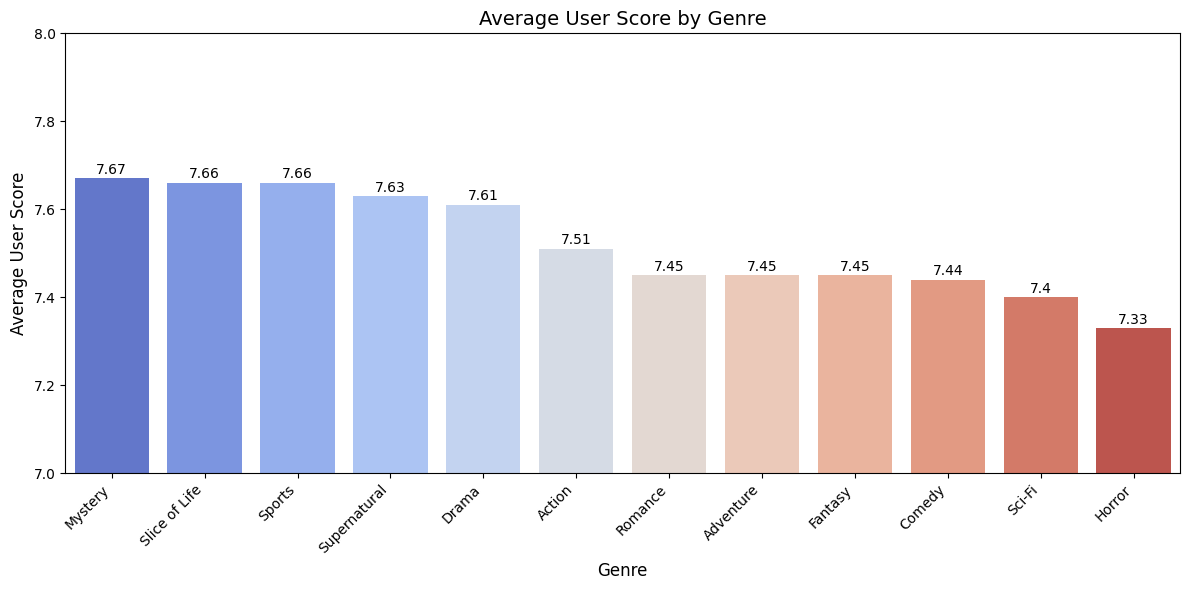

In [5]:
# Visualize the result by using vertical bar chart
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(
    x='Genre',
    y='Average User Score',
    data=genre_scores,
    palette='coolwarm',
    hue='Genre',
    legend=False
)

# Adjust Y-axis range to emphasize differences
plt.ylim(7, 8)  # Focus on the range of values

# Add specific values on top of each bar
for index, row in genre_scores.iterrows():
    bar_plot.text(
        x=index,
        y=row['Average User Score'] + 0.01,  # Position above the bar
        s=f"{row['Average User Score']}",
        ha='center',
        fontsize=10,
        color='black'
    )

plt.title("Average User Score by Genre", fontsize=14)
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Average User Score", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)

plt.tight_layout()
plt.show()

### Comments
- The audience's ratings for each anime genre are **quite good** ($\geq 7$).
- The **highest-rated** anime genre by audience is **Mystery** ($\approx 7.67$).
- The **lowest-rated** anime genre by audience is **Horror** ($\approx 7.33$).

$\rightarrow$ **Divide** the anime genres into $2$ groups, each containing $6$ genres:
- **Higher-rated** anime genres: Mystery, Slice of Life, Sports, Supernatural, Drama, Action.
- **Lower-rated** anime genres: Romance, Adventure, Fantasy, Comedy, Sci-Fi, Horror.

In [6]:
# Define 2 genre groups
higher_rated_genres = ['mystery', 'slice of life', 'sports', 'supernatural', 'drama', 'action']
lower_rated_genres = ['romance', 'adventure', 'fantasy', 'comedy', 'sci-fi', 'horror']

## Question 02: How have user ratings for different anime genres changed over time?
### Benefits of finding answer
- Understand the **changes** in audience **tastes** and **preferences** for watching anime over the years.
- **Assess** the development in the **quality** of each anime genre over the years.
### Find the answer by using data
- **Divide** anime genres into $2$ groups, each containing $6$ genres: the **highest**-rated anime genres and the **lowest**-rated anime genres (based on the results of the previous question).
- Visualize the **changes** in the quality (average ```User Score```) of anime genres over time within each group, **compare** them, and provide **comments**.

In [7]:
# Convert Premiered Season to a datetime format
def season_to_datetime(season):
    season_map = {'Winter': 1, 'Spring': 4, 'Summer': 7, 'Fall': 10}
    season_name, year = season.split()
    return pd.Timestamp(year=int(year), month=season_map[season_name], day=1)

In [8]:
# Calculate average User Score for each genre group over the seasons
season_genre_scores = (
    anime_data[['Genres', 'User Score', 'Premiered Season']]
    .assign(
        Genres=anime_data['Genres'].str.split(', '), # Split Genres into lists
        Date=anime_data['Premiered Season'].apply(season_to_datetime) # Convert to datetime
    )
    .explode('Genres') # Expand genres into individual rows
    .assign(
        Genre_Group=lambda df: df['Genres'].str.lower().apply(
            lambda x: 'Higher-rated' if x in higher_rated_genres else 'Lower-rated' if x in lower_rated_genres else None
        )
    )
    .query('Genre_Group.notnull()', engine='python') # Filter for defined genre groups
    .groupby(['Date', 'Genre_Group'], as_index=False) # Group by Date and Genre_Group
    .agg({'User Score': lambda x: round(x.mean(), 2)}) # Calculate and round the mean User Score
    .rename(columns={'User Score': 'Average User Score', 'Genre_Group': 'Genre Group'}) # Rename column
    .sort_values('Date') # Ensure chronological order
)

season_genre_scores

,Date,Genre Group,Average User Score
0,1979-04-01,Lower-rated,7.86
1,1989-04-01,Higher-rated,8.19
2,1989-04-01,Lower-rated,8.19
3,1992-04-01,Lower-rated,7.80
4,1993-10-01,Higher-rated,8.55
...,...,...,...
245,2024-04-01,Lower-rated,7.78
246,2024-07-01,Higher-rated,7.40
247,2024-07-01,Lower-rated,7.46
248,2024-10-01,Higher-rated,7.75


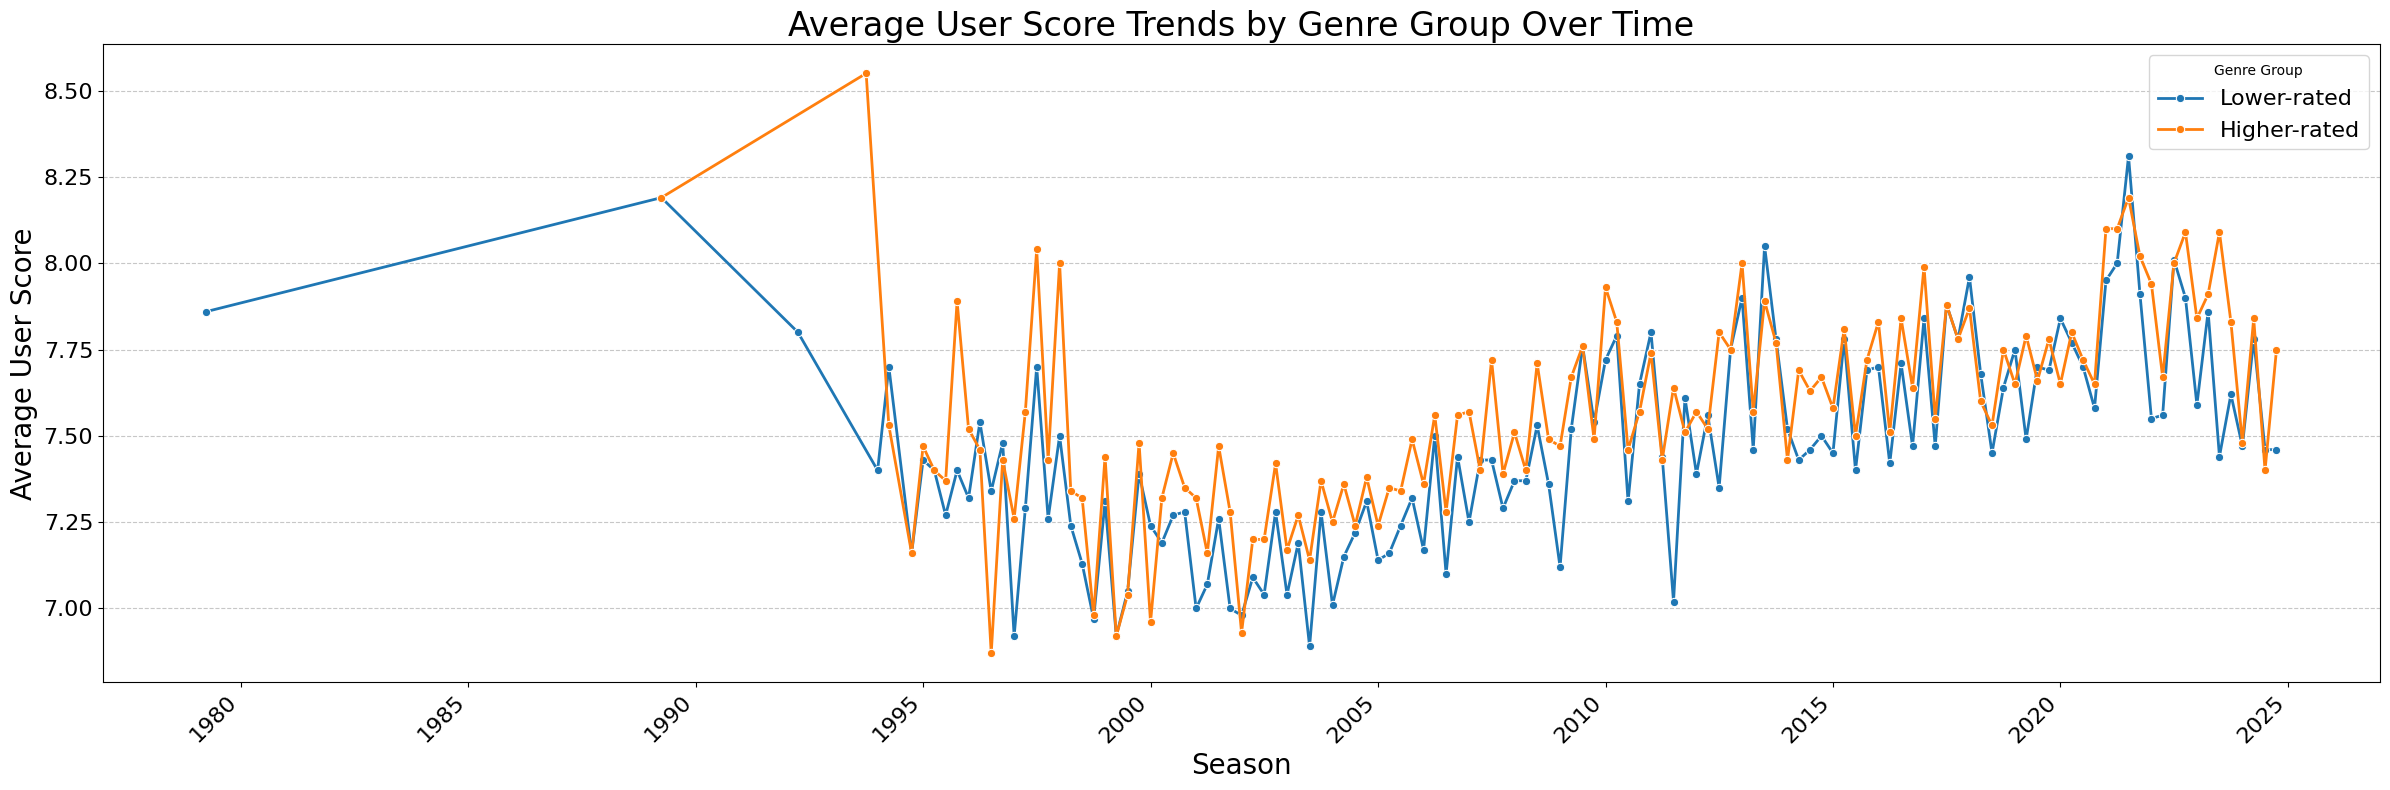

In [9]:
# Visualize the result by using line chart
plt.figure(figsize=(24, 8))
sns.lineplot(
    data=season_genre_scores,
    x='Date',
    y='Average User Score',
    hue='Genre Group',
    marker='o',
    linewidth=2
)

plt.title("Average User Score Trends by Genre Group Over Time", fontsize=24)
plt.xlabel("Season", fontsize=20)
plt.ylabel("Average User Score", fontsize=20)
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.yticks(fontsize=16)
plt.legend(title='Genre Group', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Comments

- Most of the time, **higher-rated** genres consistently receive **better** audience ratings (obviously).
- However, there are a **very small number** of **short periods** where lower-rated genres are rated **higher**, mostly concentrated in the **2010–2015** period.

$\rightarrow$ The **changes** in audience ratings over time are **incredibly complex** and **difficult to predict**, reflecting the **diverse development** of the anime market and the **shifting preferences** of viewers across different periods.

## Question 03: How has the number of anime in each genre changed over the years?
### Benefits of finding answer
- **Understand** and **analyze** the **development** of anime over the years.
- Combine with the results of the previous two questions to **identify and evaluate** the **relationship** between ```User Score```, **genres**, and the **number of anime**.
### Find the answer by using data
- Visualize the **changes** in the **number of anime** in each genre over time within each group, **compare** them, and provide **comments**.
- **Combine** with the **results** of the previous two questions to draw **final conclusions** about the **relationship** between ```User Score```, **genres**, and the **number of anime**.

In [10]:
# Calculate the number of anime for each genre group over the seasons
genre_anime_counts = (
    anime_data[['Genres', 'Premiered Season']]
    .assign(
        Genres=anime_data['Genres'].str.split(', '), # Split Genres into lists
        Date=anime_data['Premiered Season'].apply(season_to_datetime) # Convert to datetime
    )
    .explode('Genres') # Expand genres into individual rows
    .assign(
        Genre_Group=lambda df: df['Genres'].str.lower().apply(
            lambda x: 'Higher-rated' if x in higher_rated_genres else 'Lower-rated' if x in lower_rated_genres else None
        )
    )
    .query('Genre_Group.notnull()', engine='python')  # Filter for defined genre groups
    .groupby(['Date', 'Genre_Group'], as_index=False)  # Group by Date and Genre_Group
    .agg({'Genres': 'count'})  # Count the number of anime
    .rename(columns={'Genres': 'Count', 'Genre_Group': 'Genre Group'})  # Rename column
    .sort_values('Date')  # Ensure chronological order
)

genre_anime_counts

,Date,Genre Group,Count
0,1979-04-01,Lower-rated,4
1,1989-04-01,Higher-rated,1
2,1989-04-01,Lower-rated,3
3,1992-04-01,Lower-rated,1
4,1993-10-01,Higher-rated,1
...,...,...,...
245,2024-04-01,Lower-rated,25
246,2024-07-01,Higher-rated,17
247,2024-07-01,Lower-rated,34
248,2024-10-01,Higher-rated,31


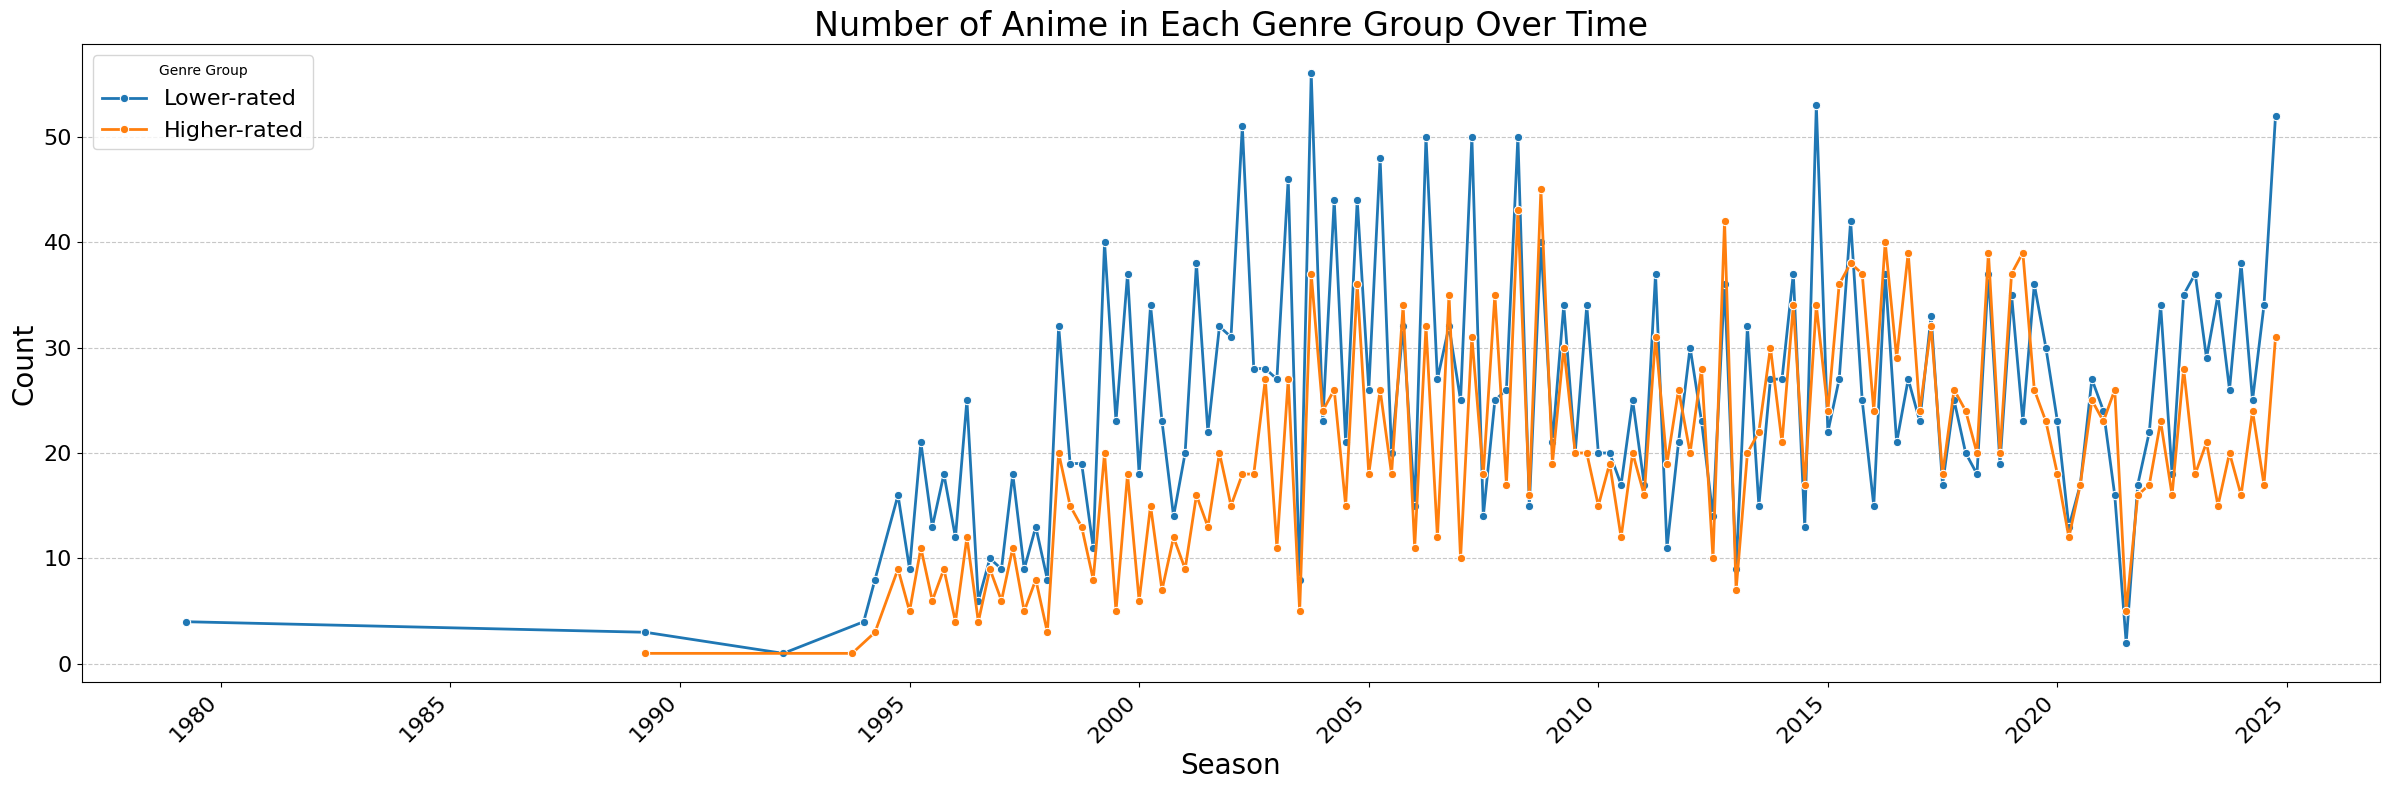

In [11]:
# Visualize the result by using line chart
plt.figure(figsize=(24, 8))
sns.lineplot(
    data=genre_anime_counts,
    x='Date',
    y='Count',
    hue='Genre Group',
    marker='o',
    linewidth=2
)
plt.title("Number of Anime in Each Genre Group Over Time", fontsize=24)
plt.xlabel("Season", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.yticks(fontsize=16)
plt.legend(title='Genre Group', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Comments
- For the majority of the time, the number of anime in the **lower-rated** genre group is always **greater than** that of the higher-rated genre group, and **significantly greater** in many cases.
- During certain periods, the number of anime in the **higher-rated** genre group **slightly surpasses** that of the lower-rated genre group.
$\rightarrow$ The **change** in the **number of anime** over time is also **very complex**, with even **significant fluctuations** between **consecutive seasons**.

## Conclusions
- There is a **relationship** between **audience ratings** and the **number of anime**: In most cases, anime with **lower ratings** tend to have a **larger quantity** compared to those with higher ratings.
- Comparing the **changes** in audience ratings with the number of anime **over time**, no **clear correlation** is observed $\rightarrow$ The relationship is **not very strong** (non-linear).
- Grouping anime by genre **helps** identify and evaluate the relationship between the feature ```User Score``` and the **number of anime** (the *target* in **data modeling**).

$\rightarrow$ ```User Score``` is an **essential feature** in the **regression** model; however, we still need to perform **additional analyses** on other features in dataset to **identify** additional necessary features, ensuring the **model's accuracy**.

In [12]:
anime_data

,ID,Title,Alternative Title (en),Media Type,Status,Premiered Season,Genres,User Score,Number of Members,Studios,Rating
0,2471,Doraemon (1979),Doraemon,tv,finished_airing,Spring 1979,"Adventure, Anthropomorphic, Comedy, Fantasy, K...",7.86,66328,Shin-Ei Animation,pg
1,813,Dragon Ball Z,Dragon Ball Z,tv,finished_airing,Spring 1989,"Action, Adventure, Comedy, Fantasy, Martial Ar...",8.19,1261770,Toei Animation,pg_13
2,966,Crayon Shin-chan,Shin Chan,tv,currently_airing,Spring 1992,"Comedy, Ecchi, School, Seinen",7.80,87291,Shin-Ei Animation,g
3,170,Slam Dunk,Slam Dunk,tv,finished_airing,Fall 1993,"School, Shounen, Sports, Team Sports",8.55,313954,Toei Animation,pg_13
4,103,Akazukin Chacha,Red Riding Hood Chacha,tv,finished_airing,Winter 1994,"Adventure, Comedy, Fantasy, Mahou Shoujo, Roma...",7.40,16950,Gallop,g
...,...,...,...,...,...,...,...,...,...,...,...
2324,56662,Trillion Game,TRILLION GAME,tv,currently_airing,Fall 2024,"Adult Cast, Drama, Seinen",7.03,18379,Madhouse,pg_13
2325,52995,Arifureta Shokugyou de Sekai Saikyou Season 3,Arifureta: From Commonplace to World's Stronge...,tv,currently_airing,Fall 2024,"Action, Adventure, Fantasy, Harem, Isekai",7.36,139526,asread.,r
2326,57611,Kimi wa Meido-sama.,You are Ms. Servant.,tv,finished_airing,Fall 2024,"Comedy, Romance",7.10,94185,Felix Film,pg_13
2327,57891,Hitoribocchi no Isekai Kouryaku,Loner Life in Another World,tv,finished_airing,Fall 2024,"Action, Adventure, Fantasy, Isekai",6.57,86450,"Passione, Hayabusa Film",pg_13


# Genre with Popularity (Number of Members)

## Question 06: How popular are the Genres? What are the Top 6 Genres with the highest popularity over the past years?

### Brief explanation
- Analyze the `Number of Members` for each `Genre` to determine the most popular genres based on average membership.

### Benefits of finding answer
- **Identify** the genres that are most appealing to the audience, while mitigating the effect of outliers.
- Help content creators focus on genres that consistently attract viewers.

### Find the answer by using data
- Use the `Genres` and `Number of Members` columns.
- Filter the data for included genres only.
- Split the `Genres` column into separate rows for each genre.
- Group the data by the `Genres` column and calculate the average `Number of Members` for each genre.
- Sort the results to identify the top 6 genres by average popularity.
- Visualize the results using a horizontal bar plot.


In [13]:
# Create a copy of the data to avoid modifying the original dataset
anime_data_copy = anime_data.copy()
anime_data_copy['Year'] = anime_data_copy['Premiered Season'].str.extract(r'(\d{4})').astype(int)

# Explode the 'Genres' column to count each genre separately
anime_data_copy['Genres'] = anime_data_copy['Genres'].str.split(', ')
anime_data_exploded = anime_data_copy.explode('Genres')
anime_data_exploded['Genres'] = anime_data_exploded['Genres'].str.lower()
filtered_data = anime_data_exploded[anime_data_exploded['Genres'].isin(included_genres)]
# Calculate the average number of members for each genre
genre_popularity = filtered_data.groupby('Genres')['Number of Members'].mean().sort_values(ascending=False).head(6)

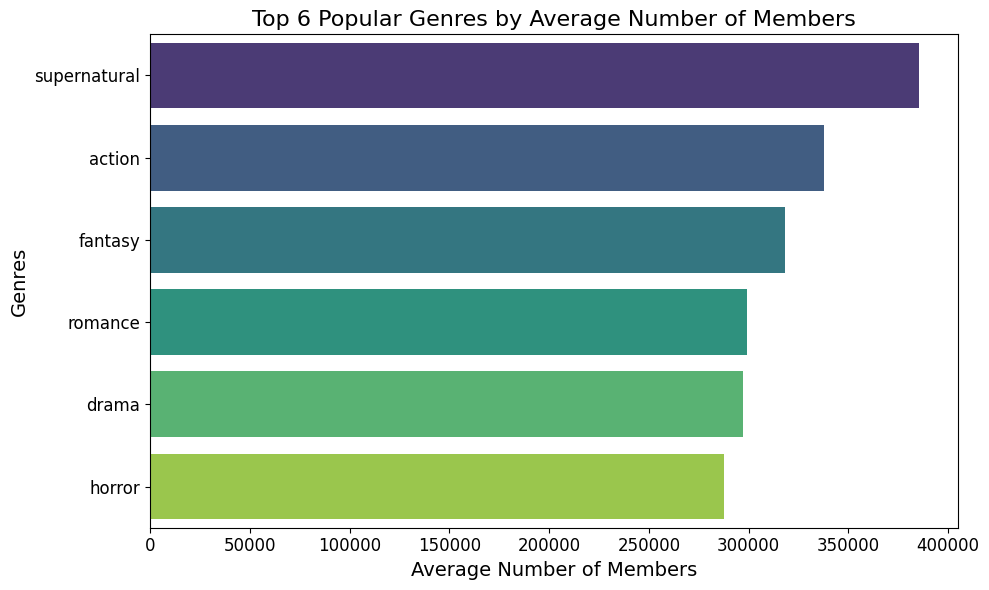

In [14]:
# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x=genre_popularity.values,
    y=genre_popularity.index,
    hue=genre_popularity.index,
    dodge=False,
    palette='viridis',
    legend=False
)

# Customize the plot
plt.title('Top 6 Popular Genres by Average Number of Members', fontsize=16)
plt.xlabel('Average Number of Members', fontsize=14)
plt.ylabel('Genres', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()

### Conclusions
- It can be seen that the 6 Anime genres that viewers are most interested in are "supernatural", "action", "fantasy", "romance, "drama" and "horror"

## Question 07: How has the interest level of the 6 most popular Genres changed over the years ?

### Brief explanation
- Analyze how the interest level of the top 6 genres (based on average membership) has changed over the years.

### Benefits of finding answer
- **Track trends** in audience interest for the most popular genres over time.
- Help creators align their strategies with shifting audience preferences.

### Find the answer by using data
- Use the `Genres`, `Year`, and `Number of Members` columns.
- Filter the data for the top 6 most popular genres: "supernatural", "action", "fantasy", "romance", "drama", and "horror".
- Group the data by the `Genres` and `Year` columns.
- Calculate the average `Number of Members` for each genre by year.
- Visualize the results using a line plot.

In [17]:
# Use the exploded data from Question 6 if it exists
if 'anime_data_exploded' in locals():
    anime_data_filtered = anime_data_exploded.copy()
else:
    # Create a copy and explode if not already done
    anime_data_filtered = anime_data_copy.copy()
    anime_data_filtered['Genres'] = anime_data_filtered['Genres'].str.split(', ')
    anime_data_filtered = anime_data_filtered.explode('Genres')

# Normalize genres to lowercase for consistency
anime_data_filtered['Genres'] = anime_data_filtered['Genres'].str.lower()

# Filter for the top 6 popular genres
top_genres = ["supernatural", "action", "fantasy", "romance", "drama", "horror"]
filtered_data = anime_data_filtered[anime_data_filtered['Genres'].isin(top_genres)]

# Calculate average members by genre and year
genre_trends = filtered_data.groupby(['Genres', 'Year'])['Number of Members'].mean().reset_index()

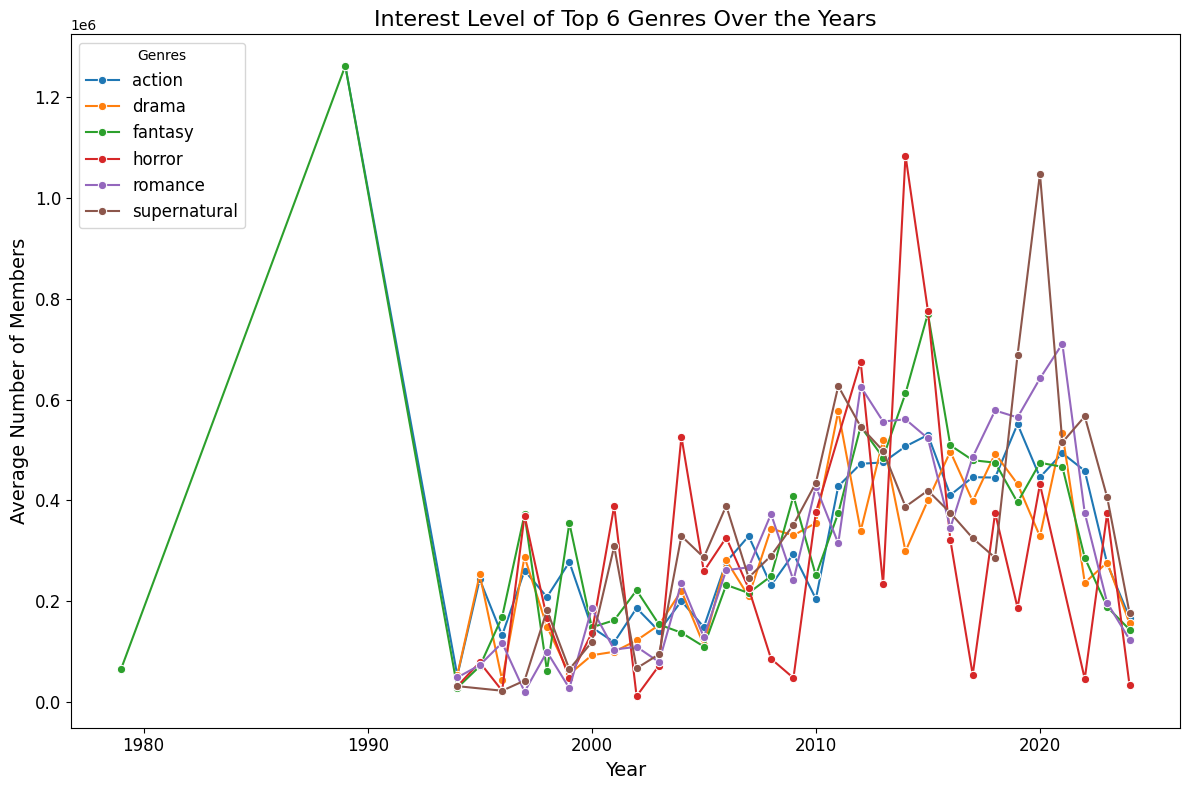

In [18]:
# Plot the trends
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=genre_trends,
    x='Year',
    y='Number of Members',
    hue='Genres',
    marker='o',
    palette='tab10'
)

# Customize the plot
plt.title('Interest Level of Top 6 Genres Over the Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Number of Members', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Genres', fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()

### General Trends:
- All genres have seen an increase in average interest from 1980 to around 2015, with a significant peak around 2015.
- After 2015, average interest has declined slightly. This may be due to studios focusing more on producing long-form series to attract larger audiences, leading to a gradual decline in smaller independent series.
### Prominence of the "Horror" and "Supernatural" Genres:
- Horror has consistently been prominent with a significantly higher average interest than other genres, especially in 2016. After 2016, there has been a slight decline.
- The Horror genre has always stood out with a significantly higher average interest level than other genres, especially in 2020. After 2020, there was a slight decline.
### "Romance", "Drama", "Fantacy" and "Action" genres:
- The "Fantacy" genre dominated the period before 2000.
- After 2000, all four genres had a steady growth in viewership, and the difference was not much.

## Question 8: What are the Top 6 Genres with the least popularity over the past years?

### Brief explanation
- Identify the 6 genres with the least average popularity over the past years based on `Number of Members`.

### Benefits of finding answer
- **Highlight** the genres that are struggling to capture audience interest.
- Help creators focus on improving or rebranding these genres to attract more viewers.

### Find the answer by using data
- Use the `Genres` and `Number of Members` columns.
- Filter the data for included genres only.
- Split the `Genres` column into separate rows for each genre.
- Group the data by the `Genres` column and calculate the average `Number of Members` for each genre.
- Sort the results to identify the 6 genres with the least average popularity.
- Visualize the results using a horizontal bar plot.

In [20]:
anime_data_filtered['Genres'] = anime_data_filtered['Genres'].str.lower()
anime_data_filtered = anime_data_filtered[anime_data_filtered['Genres'].isin(included_genres)]

# Calculate the average number of members for each genre
genre_popularity = anime_data_filtered.groupby('Genres')['Number of Members'].mean()

# Identify the 6 least popular genres
top_least_popular_genres = genre_popularity.nsmallest(6)

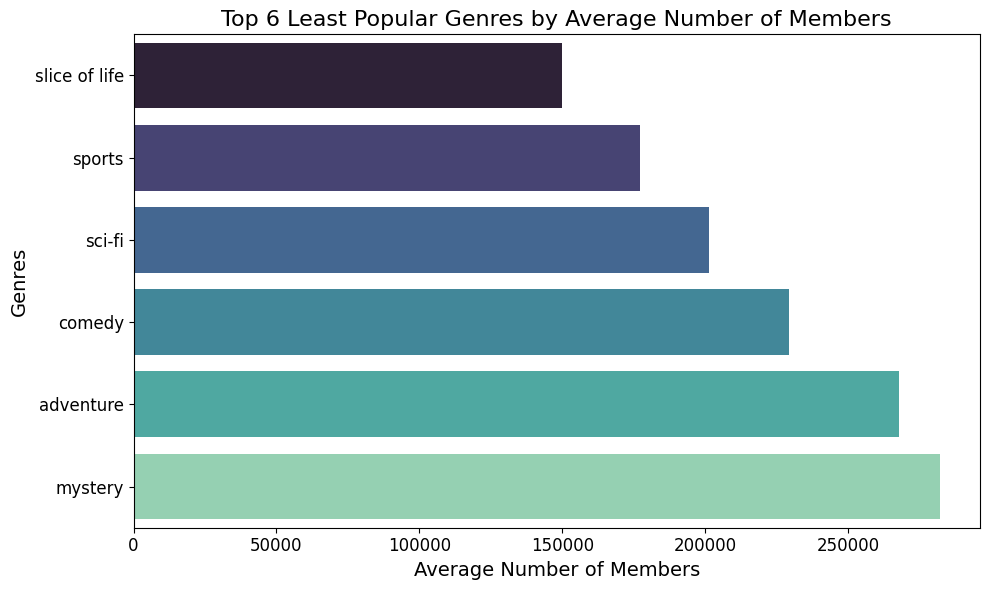

In [21]:
# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_least_popular_genres.values,
    y=top_least_popular_genres.index,
    hue=top_least_popular_genres.index,
    palette='mako',
    dodge=False,
    legend=False
)

# Customize the plot
plt.title('Top 6 Least Popular Genres by Average Number of Members', fontsize=16)
plt.xlabel('Average Number of Members', fontsize=14)
plt.ylabel('Genres', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()

### Conclusions
- It can be seen that the 6 Anime genres that viewers are least interested in are "slice of life", "sports", "sci-fi", "comedy", "adventure" and "mystery".

## Question 9: How has the interest level of the 6 least popular Genres changed over the years?

### Brief explanation
- Analyze how the interest level of the 6 least popular genres (based on average membership) has changed over the years.

### Benefits of finding answer
- **Track trends** in audience interest for the least popular genres over time.
- Help creators identify opportunities to revitalize underperforming genres.

### Find the answer by using data
- Use the `Genres`, `Year`, and `Number of Members` columns.
- Filter the data for the 6 least popular genres: "slice of life", "sports", "sci-fi", "comedy", "adventure", and "mystery".
- Group the data by the `Genres` and `Year` columns.
- Calculate the average `Number of Members` for each genre by year.
- Visualize the results using a line plot.

In [23]:
# Filter for the 6 least popular genres
least_popular_genres = ["slice of life", "sports", "sci-fi", "comedy", "adventure", "mystery"]
filtered_data = anime_data_filtered[anime_data_filtered['Genres'].isin(least_popular_genres)]

# Calculate average members by genre and year
genre_trends = filtered_data.groupby(['Genres', 'Year'])['Number of Members'].mean().reset_index()

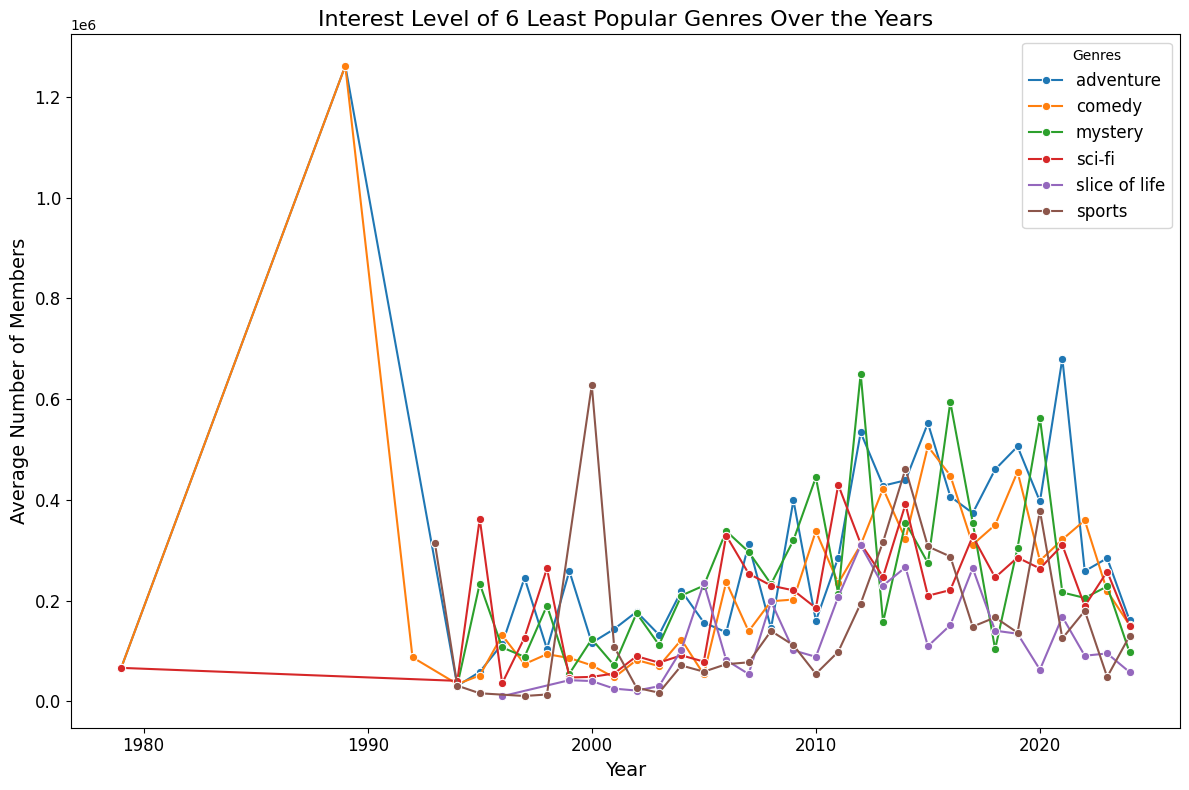

In [24]:
# Plot the trends
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=genre_trends,
    x='Year',
    y='Number of Members',
    hue='Genres',
    marker='o',
    palette='tab10'
)

# Customize the plot
plt.title('Interest Level of 6 Least Popular Genres Over the Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Number of Members', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Genres', fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()

### General trends:
- All genres tend to have a steady growth in viewership from 2001 to 2021.
### "Comedy" and "sports" genres:
- "Comedy" is the main trend of the anime genre, peaking in 1990, followed by a decline in the number of viewers interested in this genre
- "Sports" appeared in 1994 and had a peak in 2000, followed by a decline and steady growth with other genres.

## Question 10: Change in the number of anime of the 6 highest/lowest genres over the years?

### Brief explanation
- Analyze how the number of anime in the 6 most popular and 6 least popular genres has changed over the years.

### Benefits of finding answer
- **Track production trends** in anime genres to understand industry focus.
- Help studios decide which genres to prioritize or revitalize.

### Find the answer by using data
- Use the `Genres` and `Year` columns.
- Filter the data for the 6 most popular genres: "supernatural", "action", "fantasy", "romance", "drama", and "horror".
- Filter the data for the 6 least popular genres: "slice of life", "sports", "sci-fi", "comedy", "adventure", and "mystery".
- Count the number of anime for each genre by year.
- Visualize the results using two line plots: one for the most popular genres and one for the least popular genres.


In [26]:
# Define the top 6 most popular genres and the least popular genres
top_genres = ["supernatural", "action", "fantasy", "romance", "drama", "horror"]
least_popular_genres = ["slice of life", "sports", "sci-fi", "comedy", "adventure", "mystery"]

# Filter data for both sets of genres
top_genres_data = anime_data_filtered[anime_data_filtered['Genres'].isin(top_genres)]
least_genres_data = anime_data_filtered[anime_data_filtered['Genres'].isin(least_popular_genres)]

# Count the number of anime for each genre by year
top_genres_count = top_genres_data.groupby(['Genres', 'Year']).size().reset_index(name='Anime Count')
least_genres_count = least_genres_data.groupby(['Genres', 'Year']).size().reset_index(name='Anime Count')

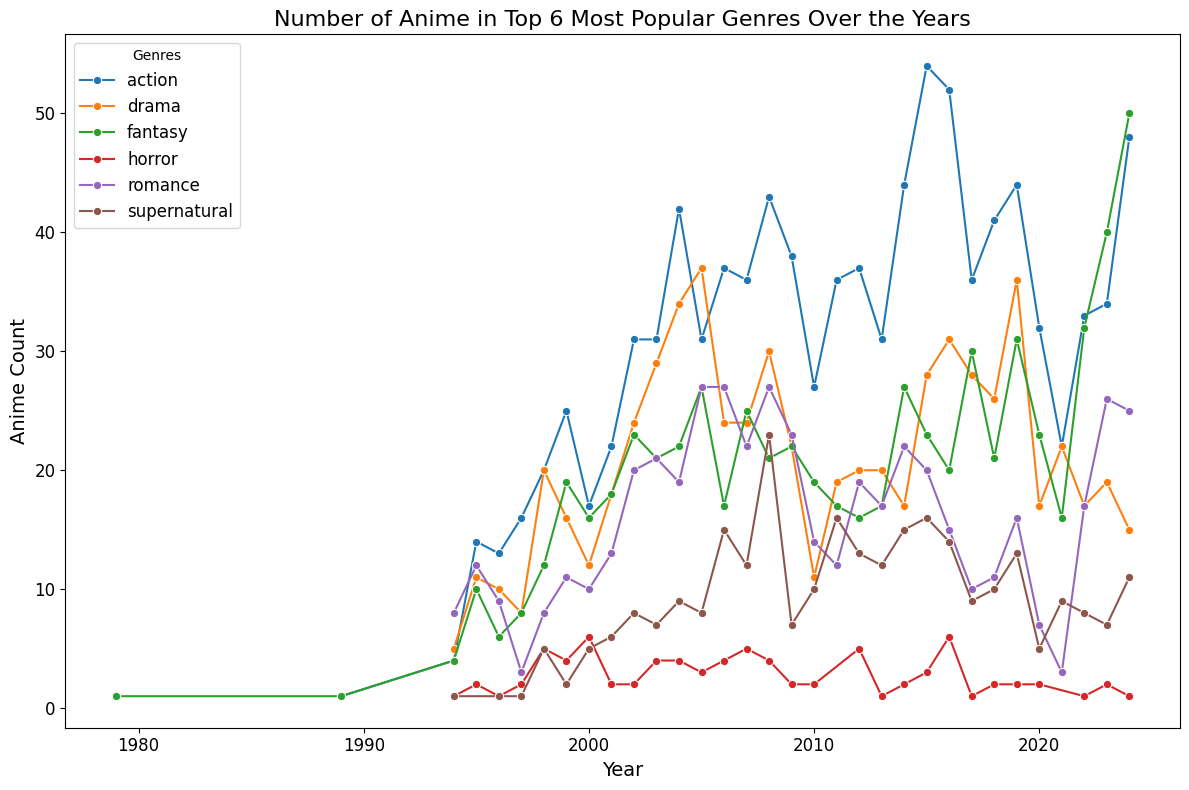

In [27]:
# Plot for top 6 most popular genres
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=top_genres_count,
    x='Year',
    y='Anime Count',
    hue='Genres',
    marker='o',
    palette='tab10'
)
plt.title('Number of Anime in Top 6 Most Popular Genres Over the Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Anime Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Genres', fontsize=12)
plt.tight_layout()
plt.show()

### General growth trends:
- The number of anime in the 6 most popular genres has been increasing significantly from 1995 to 2018.
- This steady increase shows that producers have invested heavily in genres that attract a large audience such as Action, Drama, and Fantasy.
- The number of anime series has been decreasing from 2018 to 2020, then gradually increasing again by 2024.
- Genres such as Horror and Supernatural have maintained a more stable growth rate, not exploding but still maintaining regular production.

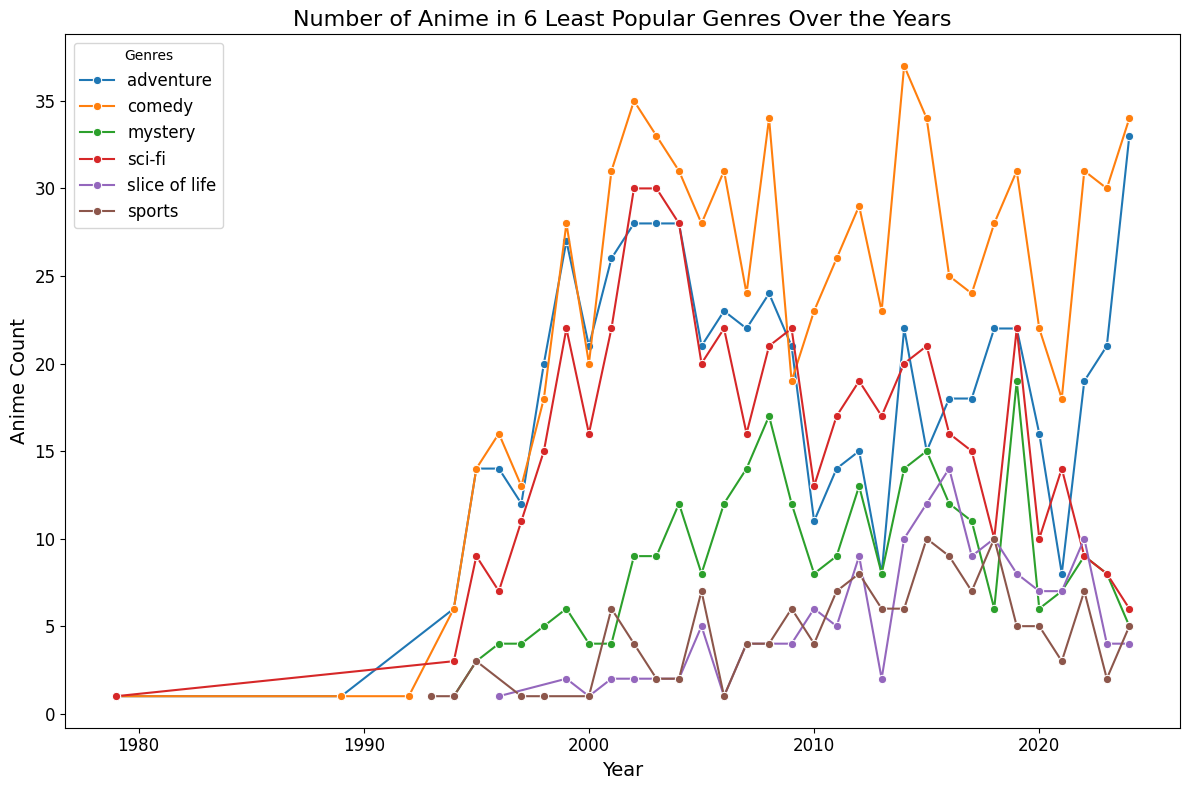

In [28]:
# Plot for 6 least popular genres
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=least_genres_count,
    x='Year',
    y='Anime Count',
    hue='Genres',
    marker='o',
    palette='tab10'
)
plt.title('Number of Anime in 6 Least Popular Genres Over the Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Anime Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Genres', fontsize=12)
plt.tight_layout()
plt.show()

### General growth trends:
- The number of anime in the 6 least popular genres shows a slower but steady increase from 1990 to 2010, with some fluctuations.
- Comedy and Adventure genres have consistently led in production among the less popular genres, showing a strong audience preference despite their overall ranking.
- Sci-Fi experienced a notable peak in the early 2000s but has declined in production in recent years.
- Slice of Life and Sports genres have shown more stable production rates, with slight increases in popularity from 2010 onward.